In [1]:
#Importing all the relevant libraries


import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
!pip install gensim
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
!pip install pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing the dataset 

tweets = pd.read_csv("data_elonmusk.csv",encoding ='latin1')
tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop('row ID', axis='columns')
print("Number of tweets: ",len(tweets['Tweet']))


Number of tweets:  3218


In [3]:
tweets.head(5)

,Tweet,Time,Retweet from,User
0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [4]:
#Running EDA on the tweets

'''import plotly.plotly as py
import plotly.graph_objs as go
'''
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [5]:
# Preparing a corpus for analysis and checking first 10 entries

corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)
        
corpus[0:10]

["@MeltingIce Assuming max acceleration of 2 to 3 g's, but in a comfortable direction. Will feel like a mild to moder? https://t.co/fpjmEgrHfC",
 'RT @SpaceX: BFR is capable of transporting satellites to orbit, crew and cargo to the @Space_Station and completing missions to the Moon an?',
 '@bigajm Yup :)',
 'Part 2 https://t.co/8Fvu57muhM',
 'Fly to most places on Earth in under 30 mins and anywhere in under 60. Cost per seat should be? https://t.co/dGYDdGttYd',
 'RT @SpaceX: Supporting the creation of a permanent, self-sustaining human presence on Mars. https://t.co/kCtBLPbSg8 https://t.co/ra6hKsrOcG',
 'BFR will take you anywhere on Earth in less than 60 mins https://t.co/HWt9BZ1FI9',
 'Mars City\nOpposite of Earth. Dawn and dusk sky are blue on Mars and day sky is red. https://t.co/XHcZIdgqnb',
 'Moon Base Alpha https://t.co/voY8qEW9kl',
 "Will be announcing something really special at today's talk https://t.co/plXTBJY6ia"]

In [6]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/var/folders/cp/kh08kngs55q_6jww3m67v7b40000gn/T" will be used to save temporary dictionary and corpus.


In [7]:
# removing common words 
#tokenization

list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

print(dictionary)
print(dictionary.token2id)

2020-04-03 00:02:19,656 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-03 00:02:19,709 : INFO : built Dictionary(11842 unique tokens: ['2', '3', '@meltingice', 'acceleration', 'assuming']...) from 3218 documents (total 30256 corpus positions)
2020-04-03 00:02:19,710 : INFO : saving Dictionary object under /var/folders/cp/kh08kngs55q_6jww3m67v7b40000gn/T/elon.dict, separately None
2020-04-03 00:02:19,715 : INFO : saved /var/folders/cp/kh08kngs55q_6jww3m67v7b40000gn/T/elon.dict


Dictionary(11842 unique tokens: ['2', '3', '@meltingice', 'acceleration', 'assuming']...)
{'2': 0, '3': 1, '@meltingice': 2, 'acceleration': 3, 'assuming': 4, 'comfortable': 5, 'direction.': 6, 'feel': 7, "g's,": 8, 'https://t.co/fpjmegrhfc': 9, 'like': 10, 'max': 11, 'mild': 12, 'moder?': 13, '@space_station': 14, '@spacex:': 15, 'an?': 16, 'bfr': 17, 'capable': 18, 'cargo': 19, 'completing': 20, 'crew': 21, 'missions': 22, 'moon': 23, 'orbit,': 24, 'satellites': 25, 'transporting': 26, ':)': 27, '@bigajm': 28, 'yup': 29, 'https://t.co/8fvu57muhm': 30, 'part': 31, '30': 32, '60.': 33, 'anywhere': 34, 'be?': 35, 'cost': 36, 'earth': 37, 'fly': 38, 'https://t.co/dgyddgttyd': 39, 'mins': 40, 'per': 41, 'places': 42, 'seat': 43, 'creation': 44, 'https://t.co/kctblpbsg8': 45, 'https://t.co/ra6hksrocg': 46, 'human': 47, 'mars.': 48, 'permanent,': 49, 'presence': 50, 'self-sustaining': 51, 'supporting': 52, '60': 53, 'https://t.co/hwt9bz1fi9': 54, 'less': 55, 'take': 56, 'blue': 57, 'city': 

In [8]:
corpus = [dictionary.doc2bow(text) for text in texts]
# To be used later
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)

2020-04-03 00:03:18,778 : INFO : storing corpus in Matrix Market format to /var/folders/cp/kh08kngs55q_6jww3m67v7b40000gn/T/elon.mm
2020-04-03 00:03:18,780 : INFO : saving sparse matrix to /var/folders/cp/kh08kngs55q_6jww3m67v7b40000gn/T/elon.mm
2020-04-03 00:03:18,781 : INFO : PROGRESS: saving document #0
2020-04-03 00:03:18,804 : INFO : PROGRESS: saving document #1000
2020-04-03 00:03:18,826 : INFO : PROGRESS: saving document #2000
2020-04-03 00:03:18,853 : INFO : PROGRESS: saving document #3000
2020-04-03 00:03:18,859 : INFO : saved 3218x11842 matrix, density=0.079% (29959/38107556)
2020-04-03 00:03:18,860 : INFO : saving MmCorpus index to /var/folders/cp/kh08kngs55q_6jww3m67v7b40000gn/T/elon.mm.index


In [9]:
#Initializing the model

tfidf = models.TfidfModel(corpus) 

2020-04-03 00:04:00,183 : INFO : collecting document frequencies
2020-04-03 00:04:00,187 : INFO : PROGRESS: processing document #0
2020-04-03 00:04:00,210 : INFO : calculating IDF weights for 3218 documents and 11842 features (29959 matrix non-zeros)


In [10]:
#Use the model to transform vectors

corpus_tfidf = tfidf[corpus]

In [11]:
total_topics = 5

In [12]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)

# creating a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
corpus_lda = lda[corpus_tfidf] 

2020-04-03 00:06:04,744 : INFO : using symmetric alpha at 0.2
2020-04-03 00:06:04,746 : INFO : using symmetric eta at 0.2
2020-04-03 00:06:04,750 : INFO : using serial LDA version on this node
2020-04-03 00:06:04,761 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 3218 documents, updating model once every 2000 documents, evaluating perplexity every 3218 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-03 00:06:04,762 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-04-03 00:06:04,763 : INFO : PROGRESS: pass 0, at document #2000/3218
2020-04-03 00:06:05,544 : INFO : merging changes from 2000 documents into a model of 3218 documents
2020-04-03 00:06:05,550 : INFO : topic #0 (0.200): 0.006*"tesla" + 0.006*"yes" + 0.006*"model" + 0.005*"@teslamotors:" + 0.005*"like" + 0.004*"falcon" + 0.004*"@spacex:" + 0.004*"@teslamotors" + 0

In [13]:
#Displaying the first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.009*"tesla" + 0.007*"like" + 0.007*"model" + 0.005*"falcon" + 0.005*"rocket"'),
 (1,
  '0.011*"tesla" + 0.006*"new" + 0.005*"model" + 0.005*"..." + 0.005*"next"'),
 (2,
  '0.011*"model" + 0.008*"tesla" + 0.005*"@elonmusk" + 0.004*"w" + 0.004*"space"'),
 (3,
  '0.009*"launch" + 0.006*"dragon" + 0.005*"@spacex" + 0.005*"rocket" + 0.004*"@spacex:"'),
 (4,
  '0.010*"tesla" + 0.008*"good" + 0.005*"landing" + 0.005*"rocket" + 0.004*"w"')]

In [14]:
#data_lda
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}


In [15]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 79)


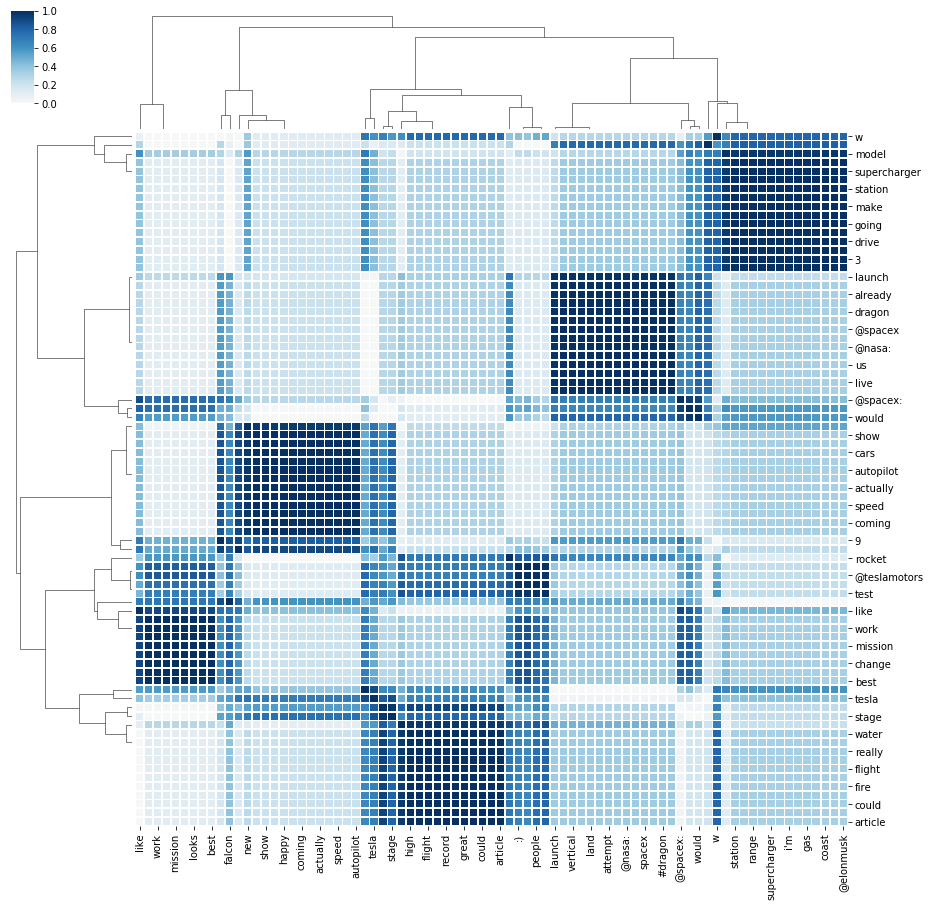

In [16]:
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()


In [17]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
4       75.602448  89.927589       1        1  46.789078
2       44.730167  38.951511       2        1  18.299273
0       95.703568   8.076515       3        1  14.660380
3       85.654060  49.002281       4        1  10.217283
1      126.580734  59.052864       5        1  10.033994, topic_info=     Category       Freq           Term      Total  loglift  logprob
329   Default  11.000000         launch  11.000000  30.0000  30.0000
580   Default  18.000000          model  18.000000  29.0000  29.0000
231   Default  28.000000          tesla  28.000000  28.0000  28.0000
135   Default   6.000000            new   6.000000  27.0000  27.0000
10    Default   7.000000           like   7.000000  26.0000  26.0000
322   Default   5.000000         dragon   5.000000  25.0000  25.0000
82    Default   9.000000         falcon   9.000000  24.0000  24.0000
170   Default   5.000000        @spacex   5.000000  23.0000  23.0000
15    Default   7.000000       @spacex:   7.000000  22.0000  22.0000
272   Default   6.000000            ...   6.000000  21.0000  21.0000
324   Default   5.000000           next   5.000000  20.0000  20.0000
1129  Default   3.000000           time   3.000000  19.0000  19.0000
407   Default   9.000000              w   9.000000  18.0000  18.0000
256   Default   5.000000              9   5.000000  17.0000  17.0000
1394  Default   6.000000      @elonmusk   6.000000  16.0000  16.0000
1853  Default   5.000000         thanks   5.000000  15.0000  15.0000
328   Default  10.000000        landing  10.000000  14.0000  14.0000
340   Default   1.000000   supercharger   1.000000  13.0000  13.0000
90    Default  13.000000         rocket  13.000000  12.0000  12.0000
7217  Default   1.000000           land   1.000000  11.0000  11.0000
959   Default   2.000000       software   2.000000  10.0000  10.0000
275   Default   2.000000       actually   2.000000   9.0000   9.0000
3516  Default   1.000000          coast   1.000000   8.0000   8.0000
991   Default   5.000000            due   5.000000   7.0000   7.0000
1250  Default   1.000000        station   1.000000   6.0000   6.0000
1027  Default   2.000000        mission   2.000000   5.0000   5.0000
27    Default   6.000000             :)   6.000000   4.0000   4.0000
881   Default   4.000000          space   4.000000   3.0000   3.0000
1106  Default   2.000000           live   2.000000   2.0000   2.0000
314   Default   4.000000  @teslamotors:   4.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
25     Topic5   0.510329     satellites   0.783976   1.8699  -6.4500
2293   Topic5   0.433189            co2   0.661985   1.8751  -6.6139
1126   Topic5   0.584271         please   1.089646   1.6759  -6.3147
135    Topic5   2.009231            new   6.703040   1.0944  -5.0796
3719   Topic5   0.611205           show   1.231561   1.5986  -6.2696
215    Topic5   0.542121          time.   1.037171   1.6504  -6.3896
272    Topic5   1.596411            ...   6.104728   0.9579  -5.3096
2474   Topic5   0.584436           goes   1.174389   1.6013  -6.3144
959    Topic5   0.911329       software   2.468797   1.3026  -5.8702
324    Topic5   1.501475           next   5.967957   0.9192  -5.3709
231    Topic5   3.535943          tesla  28.767794   0.2029  -4.5143
1499   Topic5   0.583282          sales   1.187012   1.5887  -6.3164
275    Topic5   0.918414       actually   2.894107   1.1514  -5.8624
1713   Topic5   0.562204          good.   1.177024   1.5603  -6.3532
256    Topic5   1.199462              9   5.636349   0.7518  -5.5955
139    Topic5   0.641260           soon   1.609452   1.3790  -6.2216
82     Topic5   1.347576         falcon   9.145313   0.3843  -5.4790
580    Topic5   1.697175          model  18.193666  -0.0729  -5.2484
10     Topic5   1.008397           like   7.824895   0.2502  -5.7690
342    Topic5   0.695926         coming